# Notebook 2: Collocation points for PINN

In this notebook, we will come back to the loss function we defined before for PINNs, introducing the concept of collocation points and using them to enhance the performance of the network from the first notebook. We will continue using the SI model as an example.

## Importing packages and necessary files
Here, we import packages and the NNetwork class, as used in the previous notebook.

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import grad
import torch.optim as optim
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from neuralnet import NNetwork
torch.manual_seed(1234)  # setting pytorch seed

In [4]:
@np.vectorize
def model_SI(t, beta, I0):
    # Returns the analytical solution of the SI model for:
    ## Time t 
    ## Transmissibility beta
    ## Initial condition I0
    return (I0*np.exp(beta*t))/((1 - I0) + I0*np.exp(beta*t))

## Calculating $I(t)$ dynamics
As done in the previous notebook, we compute the $I(t)$ values, then used for training and evaluating networks. 

In [5]:
t = np.linspace(0, 500, 500)
beta = 0.1
I0 = 0.1
y = model_SI(t, beta, I0)
df = pd.DataFrame({'t': t[0:50], 'infected': y[0:50]}) # training data

## PINN loss and collocation points

The loss we defined for PINNs has three basic components: the data loss, the boundary condition loss and the physics loss, which we calculated previously as:
\begin{aligned}
\mathcal{L_{\mathrm{data}}} = \sum_t (\hat{I(t)} - I(t))^2 \\
\mathcal{L_{\mathrm{boundary}}} = (\hat{I}(t = 0) - I_0)^2 \\
\mathcal{L_{\mathrm{physics}}} = \sum_t \Bigg(\widehat{\frac{dI}{dt} (t)} - \beta (1 - \widehat{I(t)}) \widehat{I(t)} \Bigg)^{2}
\end{aligned}
For calculating the data and boundary losses, we actually use training values of $I(t)$. In the first case, we use the full $I(t)$ values and measure their distance with the $\hat{I(t)}$ predicted by the network. For the boundary loss, we compare the provided initial condition with the predicted $\hat{I(0)}$.

Nevertheless, no data on $I(t)$ is used in the physics loss expression. Rather, this term is calculated only using the $\hat{I(t)}$ values, as well as the gradients computed by using the <code>autograd</code> module. This way, it is possible to use a different set of points to calculate this loss, by specifing some specific $t$ values. We willl call this $t$ points collocation points and use the notation $t_{\mathrm{col}}$ to identify them. This way, the expression of the physics loss takes the form:

\begin{aligned}
\mathcal{L_\mathrm{physics}} = \sum_{t_\mathrm{col}} \Bigg(\widehat{\frac{dI}{dt} (t_\mathrm{col})} - \beta (1 - \widehat{I(t_\mathrm{col})}) \widehat{I(t_\mathrm{col})} \Bigg)^{2}
\end{aligned}

It is worth remarking that collocation points can be defined for ranges outside the range of the training data, thus allowing for enforcing physics in other regions of the state space, which could help predict dynamics. For example, for times $t$ greater than the ones corresponding to training data. 

In this particular case, we will profit from this property of collocation points, which will exceed the range of times of training data. We define the collocation points by doing:

In [6]:
t_col = np.linspace(0, 500, 10)
df_col = pd.DataFrame({'t_col': t_col})

We can visualize the difference between collocation and training time points from the following plot:

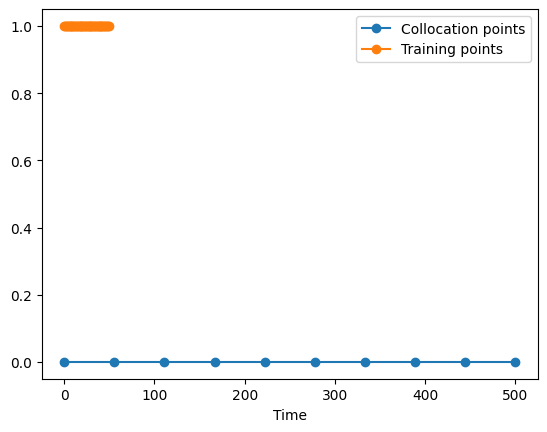

In [7]:
%matplotlib inline
plt.plot(t_col, t_col*0 + 0, '-o', label = 'Collocation points')
plt.plot(df['t'], df['t']*0 + 1, '-o', label = 'Training points')
plt.xlabel('Time')
plt.legend()
plt.show()

## Training the PINN

Similarly to what was done in the first notebook, we define tensors for training data, now differentiating this data from collocation points:

In [8]:
# training data and boundary conditions
t_nn = torch.tensor(df['t'], dtype = torch.float32).view(-1, 1).requires_grad_(True)
t_initial = torch.tensor([0.0], dtype=torch.float32).view(-1, 1)
i_nn = torch.tensor(df['infected'], dtype = torch.float32).view(-1, 1)
i_initial = torch.tensor([I0], dtype = torch.float32).view(-1, 1)

# collocation points
t_col = torch.tensor(df_col['t_col'], dtype = torch.float32).view(-1, 1).requires_grad_(True)

Now we train a network similar to the ones that we have been using, only changing the way we compute the physics loss

In [9]:
model = NNetwork(1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
n_epochs = 10000
loss_epochs = []

for epoch in range(n_epochs):
    
    optimizer.zero_grad()
    i_pred = model(t_nn)
    i_pred_initial = model(t_initial)
    i_col = model(t_col)
    
    # ODE Loss
    dx = torch.autograd.grad(i_col, t_col, torch.ones_like(i_col), create_graph=True)[0]
    loss_ode_aux = dx - beta*i_col*(1 - i_col)
    loss_ode = torch.mean(loss_ode_aux**2)
    
    # Data Loss
    loss_data = torch.mean((i_pred - i_nn)**2)
    
    # Boundary condition Loss
    loss_boundary = torch.mean((i_pred_initial - i_initial)**2)
    
    # Calculate total loss
    loss = loss_ode + loss_boundary + loss_data 
    loss_epochs.append(loss.item())
    loss.backward()
    optimizer.step()

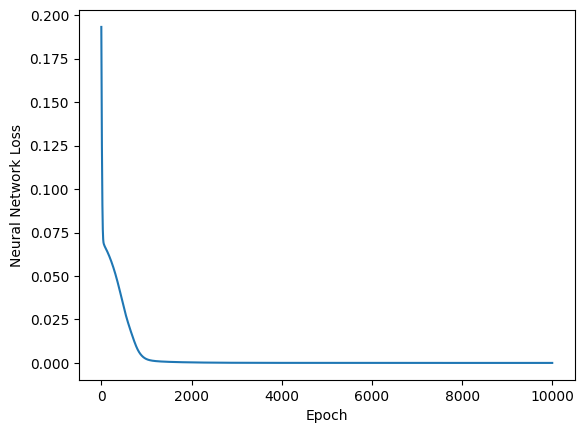

In [10]:
plt.plot(loss_epochs)
plt.xlabel('Epoch')
plt.ylabel('Neural Network Loss')
plt.show()

## Comparison with data

We compare the $I(t)$ computed analytically with the predictions from our improved PINN.  

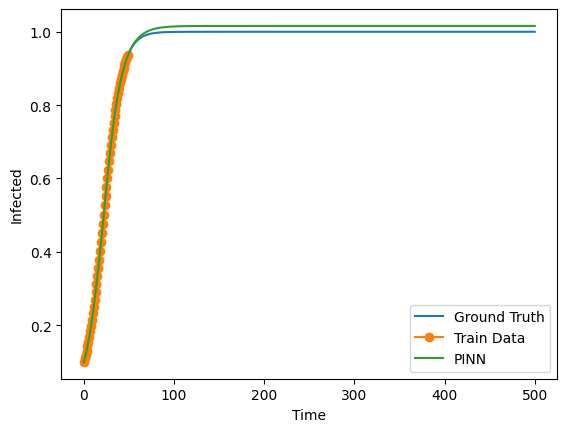

In [11]:
df_total = pd.DataFrame({'t': t, 'infected': y})
t_total = torch.tensor(df_total['t'], dtype = torch.float32).view(-1, 1)
i_pred = model(t_total)
df_total['i_pred_pinn'] = i_pred.detach().cpu().numpy()
df_total


plt.plot(df_total['t'], df_total['infected'], label = 'Ground Truth')
plt.plot(df_total['t'][0:50], df_total['infected'][0:50], '-o', label = 'Train Data')
plt.plot(df_total['t'], df_total['i_pred_pinn'], label = 'PINN')
plt.xlabel('Time')
plt.ylabel('Infected')
plt.legend()
#plt.yscale('log')
plt.show()